In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download andrewmvd/dog-and-cat-detection

 99% 1.02G/1.03G [00:04<00:00, 198MB/s]
100% 1.03G/1.03G [00:04<00:00, 268MB/s]


In [6]:
!unzip -q dog-and-cat-detection.zip

In [7]:
import os
import pathlib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *
from PIL import Image
import tensorflow as tf

In [8]:
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)
    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)
    return resized

In [9]:
def downsize_upsize_image(image, scale):
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)
    return scaled

In [10]:
def tight_crop_image(image, scale):
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)
    return image[:height, :width]

In [11]:
def crop_input(image, x, y):
    y_slice = slice(y, y + INPUT_DIM)
    x_slice = slice(x, x + INPUT_DIM)
    return image[y_slice, x_slice]

In [12]:
def crop_output(image, x, y):
    y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
    x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
    return image[y_slice, x_slice]

In [13]:
file_patten = (pathlib.Path('/content') / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]

In [14]:
dataset_paths

['/content/images/Cats_Test3534.png',
 '/content/images/Cats_Test3323.png',
 '/content/images/Cats_Test1274.png',
 '/content/images/Cats_Test2903.png',
 '/content/images/Cats_Test123.png',
 '/content/images/Cats_Test3179.png',
 '/content/images/Cats_Test124.png',
 '/content/images/Cats_Test2019.png',
 '/content/images/Cats_Test1987.png',
 '/content/images/Cats_Test580.png',
 '/content/images/Cats_Test1721.png',
 '/content/images/Cats_Test2045.png',
 '/content/images/Cats_Test2520.png',
 '/content/images/Cats_Test148.png',
 '/content/images/Cats_Test157.png',
 '/content/images/Cats_Test2563.png',
 '/content/images/Cats_Test3066.png',
 '/content/images/Cats_Test1639.png',
 '/content/images/Cats_Test2771.png',
 '/content/images/Cats_Test3603.png',
 '/content/images/Cats_Test472.png',
 '/content/images/Cats_Test1939.png',
 '/content/images/Cats_Test2876.png',
 '/content/images/Cats_Test1694.png',
 '/content/images/Cats_Test1281.png',
 '/content/images/Cats_Test1093.png',
 '/content/images/

In [15]:
SUBSET_SIZE = 1000
dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

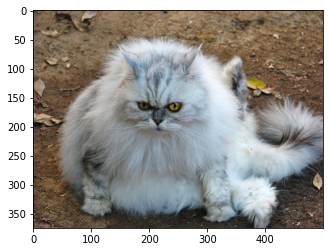

In [16]:
path = np.random.choice(dataset_paths)
img = plt.imread(path)
plt.imshow(img)

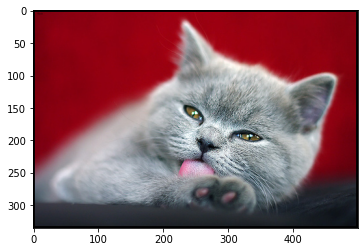

In [17]:
path = np.random.choice(dataset_paths)
img = plt.imread(path)
plt.imshow(img)

In [18]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

In [19]:
!mkdir -p data
!mkdir -p training

In [20]:
for image_path in tqdm(dataset_paths):
    filename = pathlib.Path(image_path).stem
    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8)
    image = tight_crop_image(image, SCALE)
    scaled = downsize_upsize_image(image, SCALE)

    height, width = image.shape[:2]

    for y in range(0, height - INPUT_DIM + 1, STRIDE):
        for x in range(0, width - INPUT_DIM + 1, STRIDE):
            crop = crop_input(scaled, x, y)
            target = crop_output(image, x, y)
            np.save(f'data/{filename}_{x}_{y}_input.np', crop)
            np.save(f'data/{filename}_{x}_{y}_output.np', target)

100%|██████████| 1000/1000 [04:14<00:00,  3.94it/s]


In [21]:
%cd /content/data

/content/data


In [22]:
!ls

Streaming output truncated to the last 5000 lines.
Cats_Test1090_252_42_output.np.npy   Cats_Test2692_196_56_output.np.npy
Cats_Test1090_252_56_input.np.npy    Cats_Test2692_196_70_input.np.npy
Cats_Test1090_252_56_output.np.npy   Cats_Test2692_196_70_output.np.npy
Cats_Test1090_252_70_input.np.npy    Cats_Test2692_196_84_input.np.npy
Cats_Test1090_252_70_output.np.npy   Cats_Test2692_196_84_output.np.npy
Cats_Test1090_252_84_input.np.npy    Cats_Test2692_196_98_input.np.npy
Cats_Test1090_252_84_output.np.npy   Cats_Test2692_196_98_output.np.npy
Cats_Test1090_252_98_input.np.npy    Cats_Test2692_210_0_input.np.npy
Cats_Test1090_252_98_output.np.npy   Cats_Test2692_210_0_output.np.npy
Cats_Test1090_266_0_input.np.npy     Cats_Test2692_210_112_input.np.npy
Cats_Test1090_266_0_output.np.npy    Cats_Test2692_210_112_output.np.npy
Cats_Test1090_266_112_input.np.npy   Cats_Test2692_210_126_input.np.npy
Cats_Test1090_266_112_output.np.npy  Cats_Test2692_210_126_output.np.npy
Cats_Test1090_266

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
%cd ..

/content


In [25]:
class PatchesDataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size, *args, **kwargs):
        self.batch_size = batch_size
        self.input = [*glob('data/*_input.np.npy')]
        self.output = [*glob('data/*_output.np.npy')]
        self.input.sort()
        self.output.sort()
        self.total_data = len(self.input)

    def __len__(self):
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        indices = self.random_indices()
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        return input, output

    def random_indices(self):
        return np.random.choice(list(range(self.total_data)), self.batch_size, p=np.ones(self.total_data)/self.total_data)

In [26]:
BATCH_SIZE = 1024
train_ds = PatchesDataset(BATCH_SIZE)
len(train_ds)

623

In [27]:
input, output = train_ds[0]
input.shape, output.shape

((1024, 33, 33, 3), (1024, 21, 21, 3))

In [28]:
def create_model(height, width, depth):
    input = Input(shape=(height, width, depth))
    x = Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1), kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5), kernel_initializer='he_normal')(x)
    return Model(input, output)

In [29]:
EPOCHS = 12
optimizer = Adam(learning_rate=1e-3, decay=1e-3 / EPOCHS)
model = create_model(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 33, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 64)        15616     
                                                                 
 re_lu (ReLU)                (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 re_lu_1 (ReLU)              (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 3)         2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable p

In [31]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [32]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/12
623/623 [==============================] - ETA: 0s - loss: 363.9583
Epoch 1: saving model to training/cp.ckpt
623/623 [==============================] - 995s 2s/step - loss: 363.9583
Epoch 2/12
623/623 [==============================] - ETA: 0s - loss: 116.4357
Epoch 2: saving model to training/cp.ckpt
623/623 [==============================] - 807s 1s/step - loss: 116.4357
Epoch 3/12
623/623 [==============================] - ETA: 0s - loss: 109.5001
Epoch 3: saving model to training/cp.ckpt
623/623 [==============================] - 763s 1s/step - loss: 109.5001
Epoch 4/12
623/623 [==============================] - ETA: 0s - loss: 104.2309
Epoch 4: saving model to training/cp.ckpt
623/623 [==============================] - 736s 1s/step - loss: 104.2309
Epoch 5/12
623/623 [==============================] - ETA: 0s - loss: 102.9136
Epoch 5: saving model to training/cp.ckpt
623/623 [==============================] - 730s 1s/step - loss: 102.9136
Epoch 6/12
623/623 [==========

In [33]:
path = '/content/super_resolution/model.h5'
model.save(path)
new_model = tf.keras.models.load_model(path)

In [38]:
path = np.random.choice(dataset_paths)
image = load_img(path)
image = img_to_array(image)
image = image.astype(np.uint8)
image = tight_crop_image(image, SCALE)
scaled = downsize_upsize_image(image, SCALE)

In [39]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]

In [40]:
for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
    for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
        crop = crop_input(scaled, x, y)
        image_batch = np.expand_dims(crop, axis=0)
        prediction = model.predict(image_batch)
        new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
        prediction = prediction.reshape(new_shape)
        output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
        output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
        output[output_y_slice, output_x_slice] = prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 333.5, -0.5)

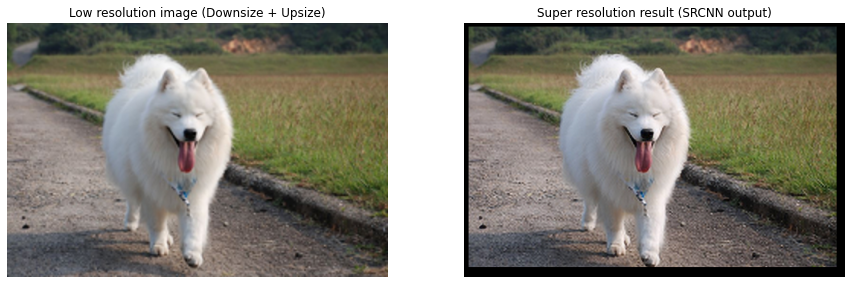

In [41]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
axis[0].imshow(np.array(scaled,np.int32))
axis[0].set_title('Low resolution image (Downsize + Upsize)')
axis[0].axis('off')

axis[1].imshow(np.array(output,np.int32))
axis[1].set_title('Super resolution result (SRCNN output)')
axis[1].axis('off')